# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Task:
- Quadratic function
- Normal noise
- Anomalies
- Anomalies detection
- LSM
- Kalman filter (matrix, 1 order)

## Imports

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [169]:
np.random.seed(1)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

## Parameters

In [170]:
PARAM_selection_size = 100
PARAM_anomaly_size = int(0.1 * PARAM_selection_size)
PARAM_widnow_size = int(0.2 * PARAM_selection_size)

PARAM_normal_mean = 0
PARAM_normal_std = 5

PARAM_max_test_pow = 11

## Functions

In [171]:
def describe_all(_data, trend_column):
    """Prints stats of all data in dictionary"""
    # create df
    df = pd.DataFrame(_data)
    # remove trend from other data
    trend_data = df[trend_column].copy()
    for column in df.columns:
            df[column] = df[column] - trend_data
    # find stats and calc var
    stats = df.describe()
    stats.loc["var"] = stats.loc["std"] ** 2
    return stats

In [172]:
def lsm_create_f(size, pol_pow):
    """
    Creating F matrix:
    1, x, x^2, ..., x^PARAM_max_pow
    """
    
    F = np.ones((size, pol_pow + 1))
    for i in range(1, pol_pow + 1):
        # pow
        F[:, i] = np.power(np.arange(0, size), i)
    return F


def lsm_coef(y, F):
    """
    Returns matrix of coef. C.
    """

    # 1-d array to row vector
    Y = y.reshape(-1, 1)
    # calc
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    # return coef
    return np.dot(FFIFT, Y)


def lsm(y, pol_pow):
    """
    LSM
    y - 1d array of values,
    pol_pow - polynomial power of model
    """

    F = lsm_create_f(len(y), pol_pow)
    C = lsm_coef(y, F)
    # returning array, reshaped from row vector to 1d
    return np.dot(F, C).reshape(-1)

In [173]:
def find_anomalies(data, sliding_window_size, lsm_pow, std3):
    """
    Returns indexes of anomalies.
    """
    anomaly_index = []
    
    for i in range(0, len(data) - sliding_window_size - 1):

        # new window
        window = data[i:(sliding_window_size + i)]
        # finding C matrix for current window
        coef = lsm_coef(window, lsm_create_f(sliding_window_size, lsm_pow))
        # prediction of next value
        y_hat = np.dot(lsm_create_f(sliding_window_size + 1, lsm_pow), coef).reshape(-1)[-1]
        
        if abs(data[sliding_window_size + i] - y_hat) > std3:
            anomaly_index.append(sliding_window_size + i)
    return anomaly_index

In [ ]:
def fix_anomalies(data, anomaly_index):
    for i in anomaly_index:
        vals = []
        # append previous value
        vals.append(data[i-1])
        # append value-anomaly
        vals.append(data[i])
        # append next values (presuming they are also value-anomalies) until normal value is found
        for j in range(i, len(anomaly_index)):
            vals.append(data[j])
            if j not in anomaly_index:
                break
        
        step = (vals[0] + vals[-1]) / (len(vals) - 1)
        for j in range(len(vals)):
            data[i+j] = vals[0] + step * (j + 1)
        

## Errors and anomalies

In [174]:
# normal error
_normal = np.random.normal(PARAM_normal_mean, PARAM_normal_std, PARAM_selection_size)

# adding anomalies at indexes, drawn from uniform distribution
# starting from PARAM_widnows_size to get std of normal error without anomalies
# (instead of manually removing anomalies from first window)
_normal_anomalies = _normal.copy()
for i in np.unique(np.random.randint(PARAM_widnow_size, PARAM_selection_size, PARAM_anomaly_size)):
    while abs(_normal_anomalies[i]) < _normal.std() * 3:
        _normal_anomalies[i] *= 2

## Data

In [175]:
data = {}

# quadratic, + noise, + anomalies
data["quadratic"] = np.square(np.linspace(0, 10, PARAM_selection_size))
data["quadratic_normal"] = data["quadratic"].copy() + _normal
data["quadratic_normal_anomalies"] = data["quadratic"].copy() + _normal_anomalies

describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies
count,100.000,100.000,100.000
mean,0.000,0.303,0.601
std,0.000,4.448,7.153
min,0.000,-11.508,-22.850
25%,0.000,-3.069,-3.187
50%,0.000,0.320,0.320
75%,0.000,3.187,3.893
max,0.000,10.928,25.251
var,0.000,19.785,51.168


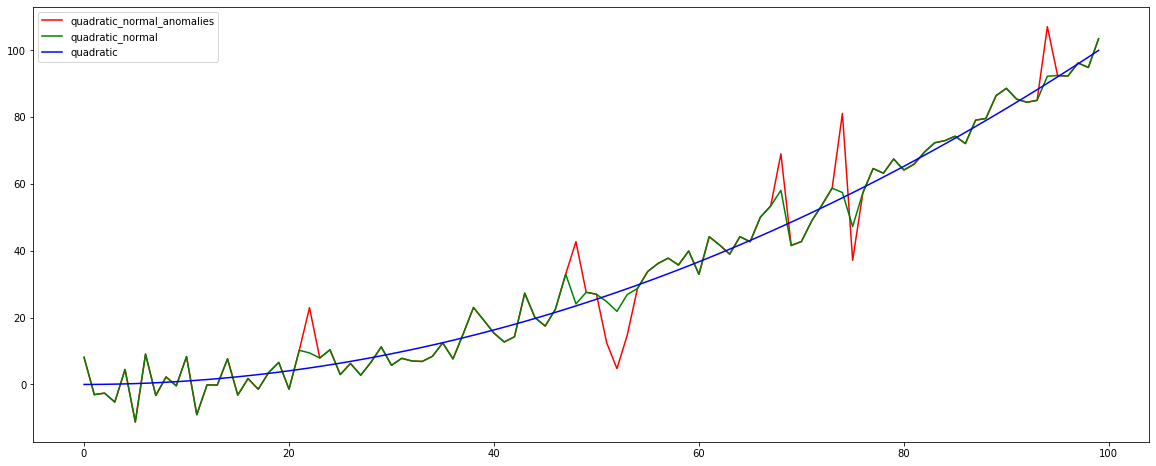

In [176]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="red")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.legend()
plt.show()

## Finding optimal polynomial power for smoothing

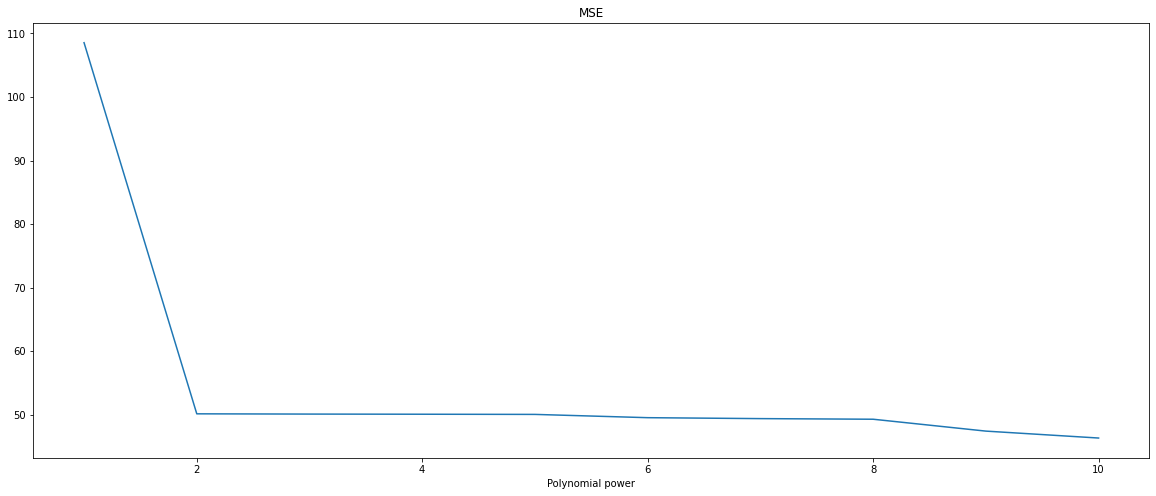

In [177]:
errs = []
pow_range = range(1, PARAM_max_test_pow)
for power in pow_range:
    errs.append((np.square(data["quadratic_normal_anomalies"] - lsm(data["quadratic_normal_anomalies"], power))).mean())

plt.title("MSE")
plt.xlabel("Polynomial power")
plt.plot(pow_range, errs)
plt.show()

In [178]:
PARAM_best_pow = 2

## Detecting Anomalies with Sliding Window

In [179]:
data["quadratic_normal_anomalies_fix"] = data["quadratic_normal_anomalies"].copy()
window = data["quadratic_normal_anomalies_fix"][:PARAM_widnow_size]

std3 = 3 * abs((window - lsm(window, PARAM_best_pow)).std())
print("Estimated 3*std:", std3)

Estimated 3*std: 16.321196217796018


In [180]:
# save indexes and values of anomalies
anomaly_index = find_anomalies(data["quadratic_normal_anomalies"], PARAM_widnow_size, 1, std3)
anomaly_value = data["quadratic_normal_anomalies"][anomaly_index]
print(anomaly_index)

[22, 48, 51, 52, 68, 74, 75, 94]


## Detected anomalies

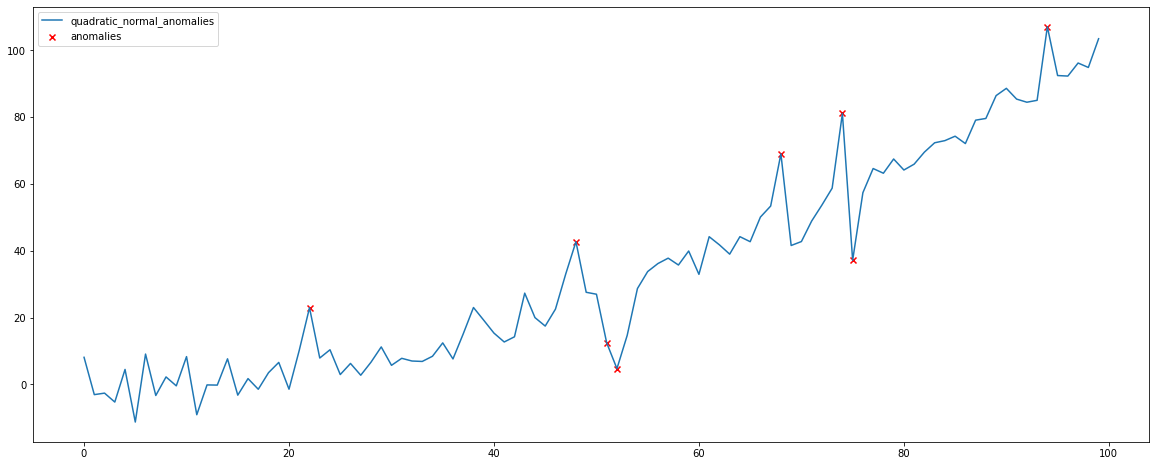

In [181]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.legend()
plt.show()

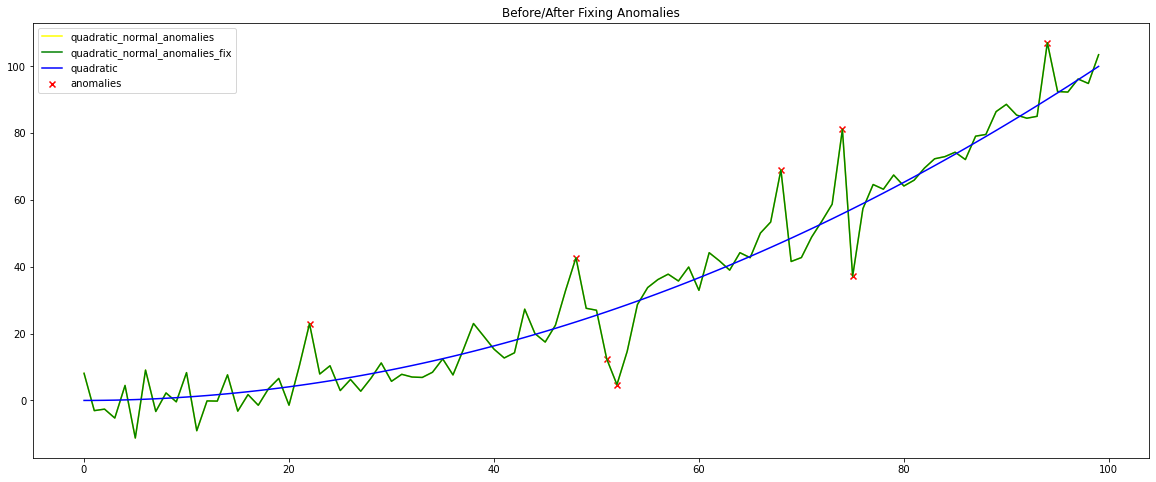

In [182]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="yellow")
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.title("Before/After Fixing Anomalies")
plt.legend()
plt.show()

## Using LSM on Data without Anomalies

In [183]:
data["quadratic_normal_anomalies_fix_lsm"] = lsm(data["quadratic_normal_anomalies_fix"], PARAM_best_pow)

## Data Stats

In [184]:
describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies,quadratic_normal_anomalies_fix,quadratic_normal_anomalies_fix_lsm
count,100.000,100.000,100.000,100.000,100.000
mean,0.000,0.303,0.601,0.601,0.601
std,0.000,4.448,7.153,7.153,0.723
min,0.000,-11.508,-22.850,-22.850,-0.545
25%,0.000,-3.069,-3.187,-3.187,-0.027
50%,0.000,0.320,0.320,0.320,0.556
75%,0.000,3.187,3.893,3.893,1.204
max,0.000,10.928,25.251,25.251,1.917
var,0.000,19.785,51.168,51.168,0.522


## Plot

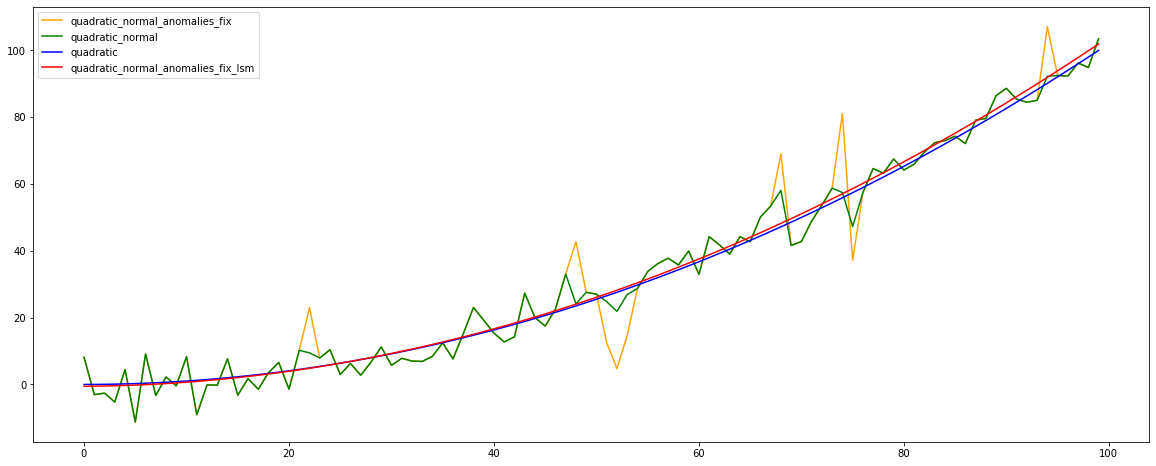

In [185]:
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="orange")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.plot(data["quadratic_normal_anomalies_fix_lsm"], label="quadratic_normal_anomalies_fix_lsm", c="red")
plt.legend()
plt.show()

## Hist

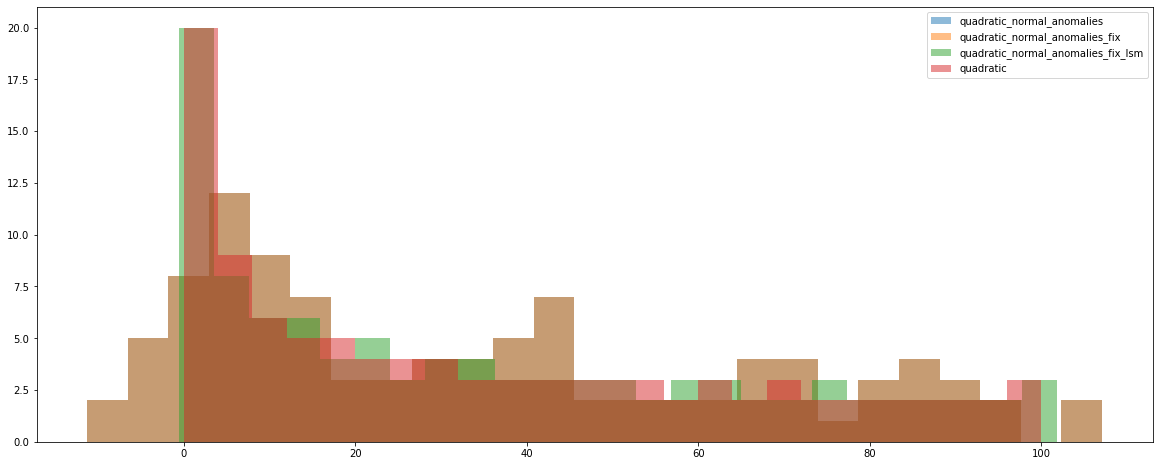

In [186]:
plt.hist(data["quadratic_normal_anomalies"], bins=25, alpha=0.5, label="quadratic_normal_anomalies")
plt.hist(data["quadratic_normal_anomalies_fix"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix")
plt.hist(data["quadratic_normal_anomalies_fix_lsm"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix_lsm")
plt.hist(data["quadratic"], bins=25, alpha=0.5, label="quadratic")
plt.legend()
plt.show()